## Imports and get data

In [1]:
%matplotlib inline

import os
import sys
import pickle
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
from datacube.storage import masking
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

sys.path.append('utils')
import dea_bom

dc = datacube.Datacube(app='Inundation_mapping')


#retrieving data
stations_pkl = Path('utils/stations.pkl')

# If cache exists, get station data from cache
if stations_pkl.exists():
    print('Loading from cache')
    stations = pickle.load(open(str(stations_pkl), 'rb'))
else:
    print('Fetching from BoM')
    stations = dea_bom.get_stations()
    pickle.dump(stations, open(str(stations_pkl), 'wb'))

# Filter list to stations with available data
stations_with_data = pickle.load(open(str('utils/stations_with_data.pkl'), 'rb'))
stations = [i for i in stations if i.name in stations_with_data]

# Preview the first five stations loaded
print(f'{len(stations)} stations loaded; e.g.:')
stations[:5]


Loading from cache
4305 stations loaded; e.g.:


[namespace(name='15 MILE @ GRETA STH', pos=(-36.61945775, 146.24407214), url='http://bom.gov.au/waterdata/services/stations/403213'),
 namespace(name='15 MILE @ WANGARATTA', pos=(-36.36666667, 146.2833333), url='http://bom.gov.au/waterdata/services/stations/403239'),
 namespace(name='16 Mile Waterhole', pos=(-18.876921, 139.360487), url='http://bom.gov.au/waterdata/services/stations/913010A'),
 namespace(name='163 Clifton Rd', pos=(-32.97808, 115.90111), url='http://bom.gov.au/waterdata/services/stations/6131318'),
 namespace(name='18 Mile Swamp HorseX', pos=(-27.49561971, 153.50836409), url='http://bom.gov.au/waterdata/services/stations/144005A')]

## Get the map

In [71]:
gauge_data, station = dea_bom.ui_select_station(stations,
                                                zoom=10,
                                                center=(-34.72, 143.17));


## Make the Flow Duration Curve, Dask load satellite data and merge with gauge data
The lat and lon of the gauge will be automatically selected, but is changeable in the first line of code below. The top 10% of flows will automatically be selected. This is also changeable in the line of code below that says # What part of the Flow Duration Curve do you want to look at?

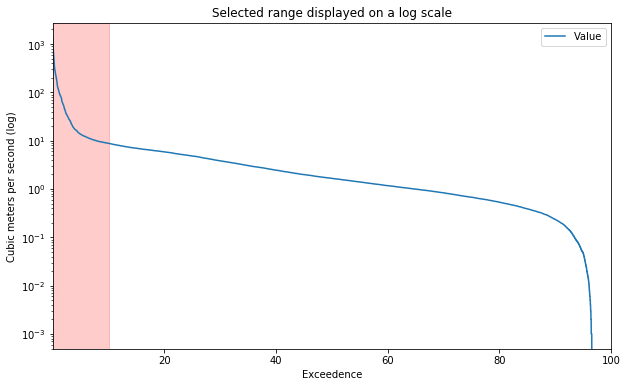

In [72]:
# The lat and lon takes the location of the gauge. You can change the lat 
# and lon to a different location if necessary, just comment out out this 
# lat, lon = pos line below and define your own.
lat, lon = station.pos

# lat =
# lon =

# The buffer is how many meters radius around the location you want to display.
buffer = 8000

# Rearranging data into a flow duration curve
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1 - (gauge_data.rownumber / len(gauge_data))) * 100

# What part of the Flow Duration Curve do you want to look at?
xaxis_lower_parameter = 0
xaxis_higher_parameter = 10

# Plot the data on a log scale
gauge_data.plot(x='Exceedence',
                y='Value',
                logy=True,
                title='Selected range displayed on a log scale',
                figsize=(10, 6))
plt.axvspan(xaxis_lower_parameter,
            xaxis_higher_parameter,
            color='red',
            alpha=0.2)
plt.ylabel('Cubic meters per second (log)');

## Query, Dask load and merge

In [77]:
# Set up a query which defines the area and time period to load data for
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1987-01-01', '2019-11-01'), # Change this date accordingly
         'crs': 'EPSG:3577'} 

# Dask load wofs_albers data (this loads the dataset parameters only, 
# not the actual satellite data)
wofs_albers = dc.load(product = 'wofs_albers', 
                      dask_chunks = {}, 
                      group_by='solar_day', 
                      **query)


# Merging satellite data with gauge data by timestamp
gauge_data_xr = gauge_data.to_xarray()
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time, method='nearest')

# Here is where it takes into account user input for the FDC
specified_level = merged_data.where((merged_data.Exceedence > xaxis_lower_parameter) & 
                                    (merged_data.Exceedence < xaxis_higher_parameter), 
                                    drop=True)

# Get list of dates to keep
date_list = specified_level.time.values

print(f'You are about to load {specified_level.time.shape[0]} satellite passes')

print(f'lat = {lat}')
print(f'lon = {lon}')

You are about to load 80 satellite passes
lat = -29.4261
lon = 149.8471


## Generate images of before and after

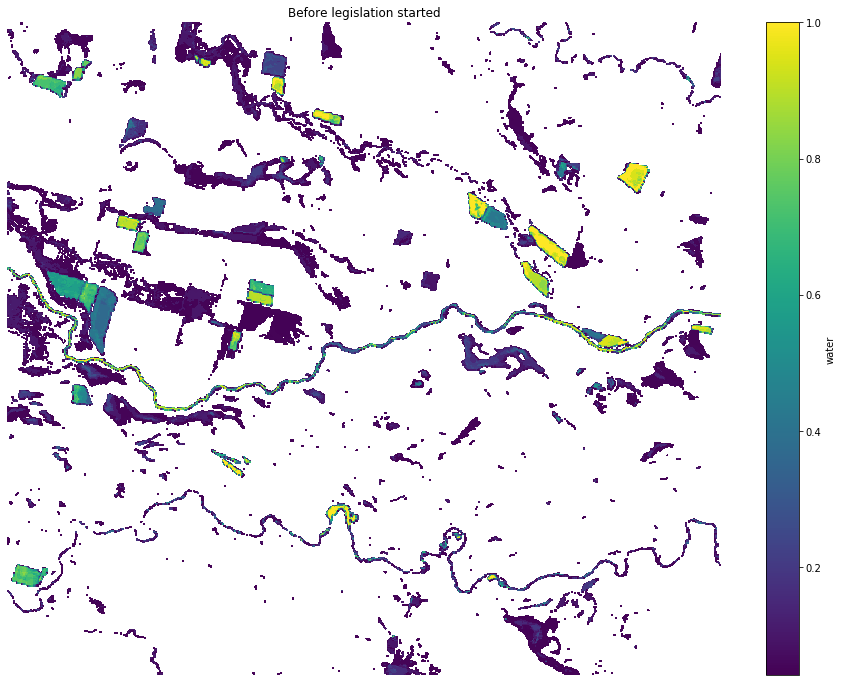

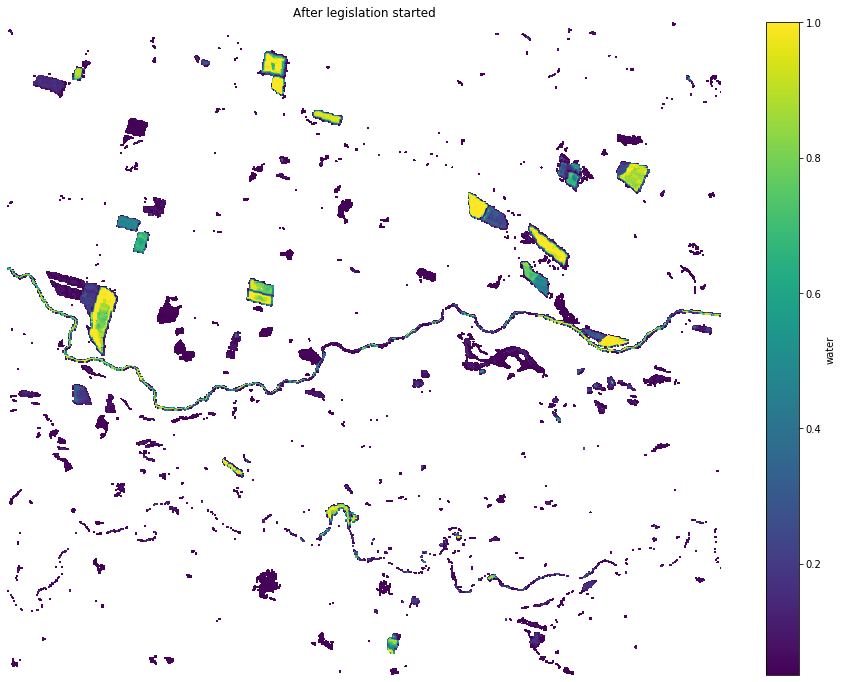

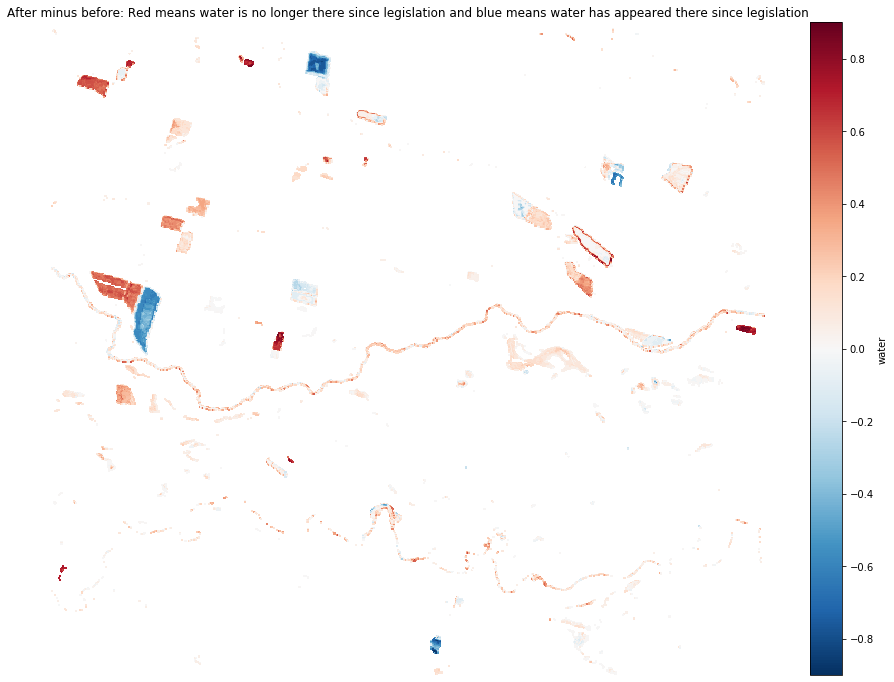

In [79]:
# Load the passes that happened during the specified flow parameters
specified_passes = wofs_albers.sel(time=date_list).compute()

# Calculate the number of cloudy pixels per timestep
cc = masking.make_mask(specified_passes.water, cloud=True)
ncloud_pixels = cc.sum(dim=['x', 'y'])

# Calculate the total number of pixels per timestep
npixels_per_slice = (specified_passes.water.shape[1] * 
                     specified_passes.water.shape[2])

# Calculate the proportion of cloudy pixels
cloud_pixels_fraction = (ncloud_pixels / npixels_per_slice)

# Filter out "too cloudy" passes (i.e. more than 50% cloud)
clear_specified_passes = specified_passes.water.isel(
    time=cloud_pixels_fraction < 0.5)


# Split by date into before and after legislation about floodplain harvesting
query_dates = clear_specified_passes

before_legislation = query_dates.loc[dict(time=slice('1987-01-01', '2008-06-01'))] # Change according to date legislation became effective
after_legislation = query_dates.loc[dict(time=slice('2008-06-02', '2019-11-13'))]

#Create parameters for the image
wet = (before_legislation == 128).sum(dim='time')
dry = (before_legislation == 0).sum(dim='time')
clear = wet + dry
frequency_before = wet / clear
frequency_before = frequency_before.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency_before = frequency_before.where(frequency_before !=0) #This is to tell it to make areas that were dry 100% of the time white

#Plotting the image
frequency_before.plot(figsize = (16, 12))
plt.axis('off')
plt.title('Before legislation started')
plt.show()


#Create parameters for the image
wet = (after_legislation == 128).sum(dim='time')
dry = (after_legislation == 0).sum(dim='time')
clear = wet + dry
frequency_after = wet / clear
frequency_after = frequency_after.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency_after = frequency_after.where(frequency_after !=0) #This is to tell it to make areas that were dry 100% of the time white

#Plotting the image
frequency_after.plot(figsize = (16, 12))
plt.axis('off')
plt.title('After legislation started')
plt.show()

delta = frequency_before - frequency_after

# Plotting the image
delta.plot(figsize = (16, 12))
plt.axis('off')
plt.title("After minus before: Red means water is no longer there since legislation and blue means water has appeared there since legislation")
plt.show()

## Save the file as a GeoTIFF

In [ ]:
# Set the output file name 
file_name = '../file_name_here.tif'

# Set up the file for writing
frequency_dataset = frequency.to_dataset()
frequency_dataset.attrs=wofs_albers.attrs

# Write GeoTIFF to a location
write_geotiff(file_name, frequency_dataset)